In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB,ComplementNB

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support,f1_score,fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

from myFunctions import plot_confusion_matrix, print_metrics,plot_feature_importances

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
%reload_ext autoreload

In [4]:
df = pd.read_csv('ModelData.csv',index_col=0)

In [5]:
df.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,...,10.0,3,2.70,1,0,75.56,10,717.2,0.105354,303
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,...,13.7,3,3.70,1,0,59.24,8,625.2,0.094754,332
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,...,12.2,5,3.29,0,0,62.29,11,539.4,0.115480,333
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,...,6.6,7,1.78,2,0,66.80,7,564.8,0.118272,255
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,...,10.1,3,2.73,3,0,52.09,6,512.0,0.101738,359


# Checking Correlation

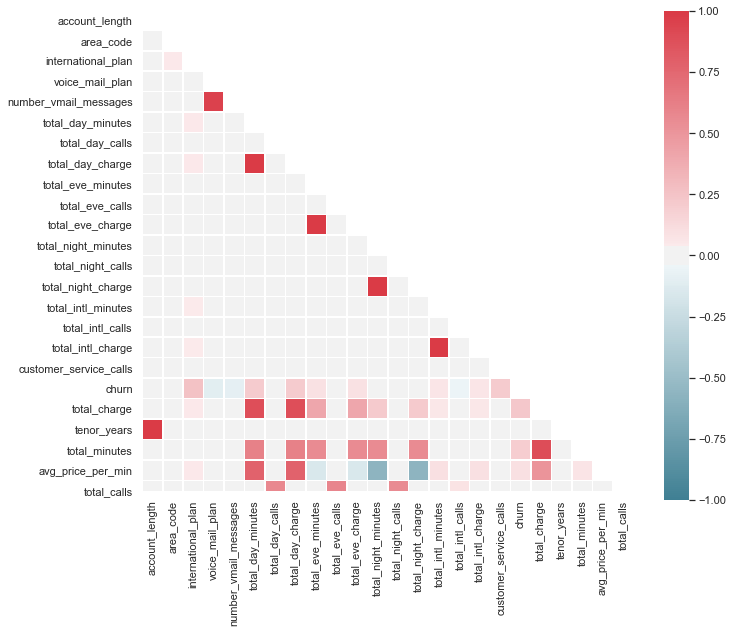

In [5]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,mask=mask,cmap=cmap, vmax=1,vmin=-1, center=0,square=True,
            linewidths=.5)

In [388]:
dfchurn = df.loc[df['churn']==True]

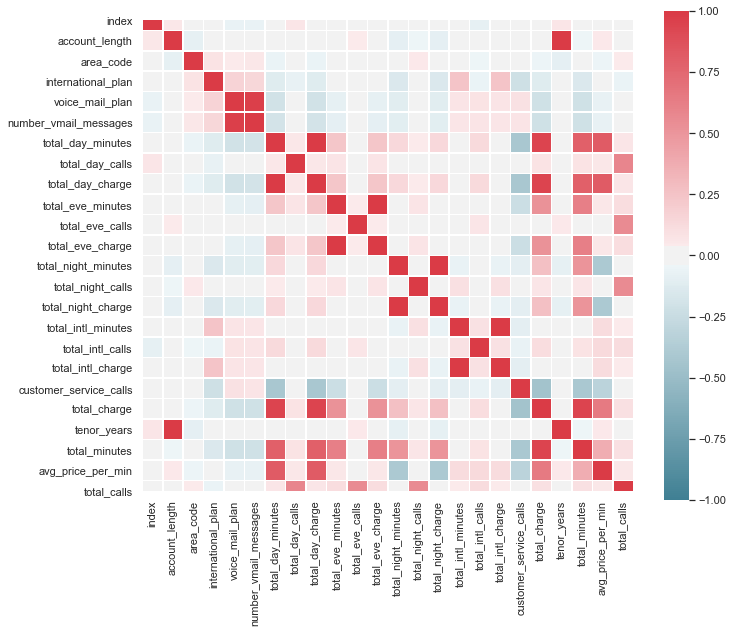

In [389]:
sns.set(style="white")

# Compute the correlation matrix
corr = dfchurn.drop('churn',axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr,cmap=cmap, vmax=1,vmin=-1, center=0,square=True,
            linewidths=.5)

# Getting Data Ready for Modelling

In [6]:
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn', 'total_charge', 'tenor_years',
       'total_minutes', 'avg_price_per_min', 'total_calls'],
      dtype='object')

In [7]:
cols =['international_plan','voice_mail_plan','total_day_minutes','total_eve_minutes','total_night_minutes',
 'total_intl_minutes','total_intl_calls','customer_service_calls','total_charge','state']

In [8]:
dfnew = df[cols]
dfnew.head()

,international_plan,voice_mail_plan,total_day_minutes,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,customer_service_calls,total_charge,state
0,0,1,265.1,197.4,244.7,10.0,3,1,75.56,KS
1,0,1,161.6,195.5,254.4,13.7,3,1,59.24,OH
2,0,0,243.4,121.2,162.6,12.2,5,0,62.29,NJ
3,1,0,299.4,61.9,196.9,6.6,7,2,66.80,OH
4,1,0,166.7,148.3,186.9,10.1,3,3,52.09,OK


In [9]:
dfnew = pd.get_dummies(dfnew)

In [10]:
y = df['churn']
X = dfnew

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=df['churn'],random_state=100)

# Dealing with class imbalance

In [12]:
y.value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [13]:
smote = SMOTE()

In [14]:
X_train_smote , y_train_smote = smote.fit_sample(X_train,y_train)

In [15]:
from collections import Counter

In [16]:
y_train_smote_counter = Counter(y_train_smote)

In [17]:
y_train.value_counts(), y_train_smote_counter

(0    2280
 1     386
 Name: churn, dtype: int64, Counter({0: 2280, 1: 2280}))

# Logistic Regression

In [18]:
#Creating logistice regression pipeline
logreg_pipeline = Pipeline([('ss', StandardScaler()), 
                              ('logreg',LogisticRegression(solver='liblinear'))])

In [19]:
params = [{"logreg__penalty":["l1","l2"],
         "logreg__fit_intercept":[True,False],
         "logreg__C":[0.5,1.0,2.0,5.0,10.0]}]

In [20]:
logreg_cv =GridSearchCV(estimator=logreg_pipeline,param_grid=params,n_jobs=-1,scoring = make_scorer(recall_score),cv=5)

In [21]:
logreg_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn'

In [22]:
logreg_best = logreg_cv.best_estimator_
logreg_cv.best_params_

{'logreg__C': 1.0, 'logreg__fit_intercept': False, 'logreg__penalty': 'l1'}

In [23]:
logreg_best.score(X_train_smote,y_train_smote),logreg_best.score(X_test,y_test)

(0.7958333333333333, 0.7556221889055472)

In [24]:
log_smote_pred = logreg_best.predict(X_test)

9.758771929824562 of False Negatives


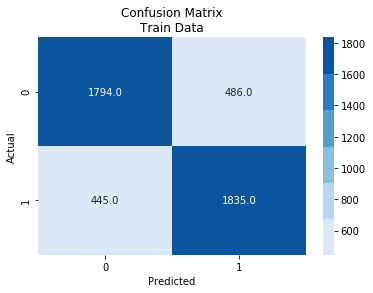

Precision Score: 0.7906074967686342
Recall Score: 0.8048245614035088
Accuracy Score: 0.7958333333333333
F1 Score: 0.7976526841990873


In [25]:
plot_confusion_matrix(y_train_smote,logreg_best.predict(X_train_smote),data='Train')
print_metrics(y_train_smote,logreg_best.predict(X_train_smote))

3.2983508245877062 of False Negatives


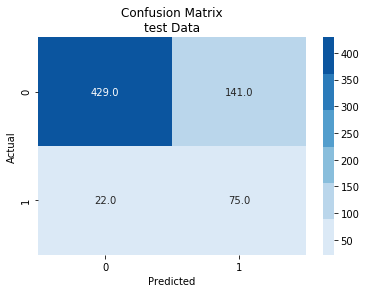

Precision Score: 0.3472222222222222
Recall Score: 0.7731958762886598
Accuracy Score: 0.7556221889055472
F1 Score: 0.47923322683706066


In [26]:
plot_confusion_matrix(y_test,log_smote_pred)
print_metrics(y_test,log_smote_pred)

3.5403540354035403 of False Negatives


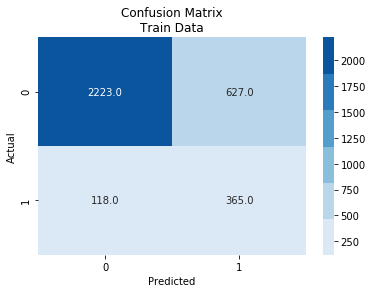

Precision Score: 0.36794354838709675
Recall Score: 0.7556935817805382
Accuracy Score: 0.7764776477647765
F1 Score: 0.49491525423728816


In [27]:
plot_confusion_matrix(y,logreg_best.predict(X),data='Train')
print_metrics(y,logreg_best.predict(X))

In [28]:
# Calculate the probability scores of each point in the training set
y_train_score = logreg_best.decision_function(X_train_smote)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train_smote, y_train_score)

# Calculate the probability scores of each point in the test set
y_test_score =logreg_best.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

AUC: 0.8622689673745769


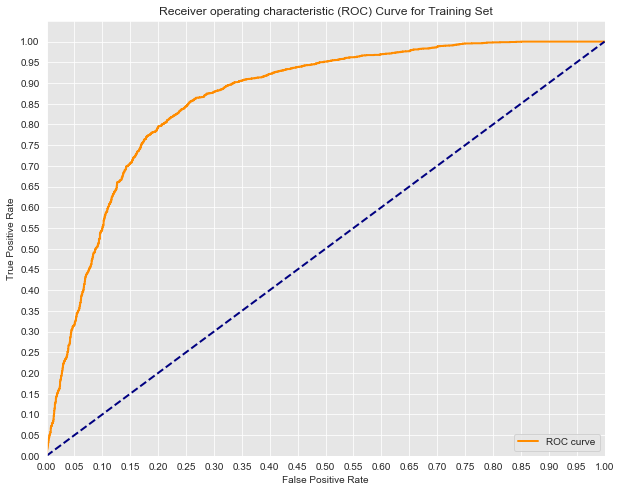

In [29]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

Test AUC: 0.8156086091517453



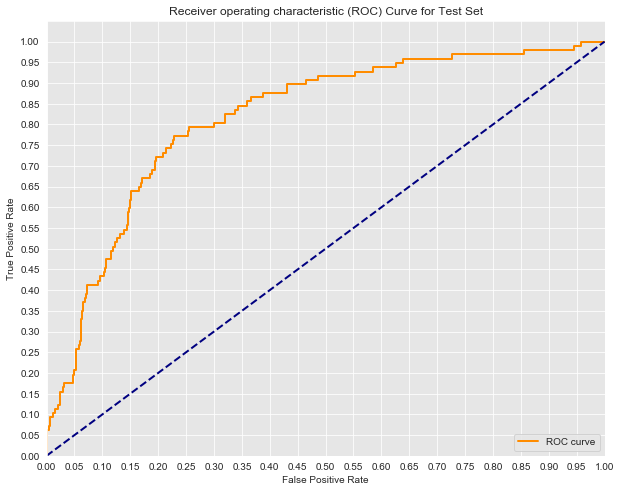

In [30]:
# ROC curve for test set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(test_fpr, test_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
print('')
plt.show()

# Random Forest

In [31]:
rf_pipeline = Pipeline([('ss', StandardScaler()),('RF',RandomForestClassifier())])

In [32]:
params = [{'RF__max_depth': [4, 5, 6], 'RF__criterion':['gini','entropy'],
         'RF__min_samples_split': [2, 5, 10], 
         'RF__min_samples_leaf': [1, 3, 5]}]

In [33]:
rf_cv = GridSearchCV(estimator=rf_pipeline,param_grid=params,scoring=make_scorer(recall_score),cv=5)

In [34]:
rf_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('RF',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                       

In [35]:
rf_best = rf_cv.best_estimator_
rf_cv.best_params_

{'RF__criterion': 'gini',
 'RF__max_depth': 6,
 'RF__min_samples_leaf': 1,
 'RF__min_samples_split': 5}

In [36]:
rf_best.score(X_train,y_train),rf_best.score(X_test,y_test)

(0.9122280570142536, 0.9220389805097451)

In [37]:
rf_preds = rf_best.predict(X_test)

8.739684921230308 of False Negatives


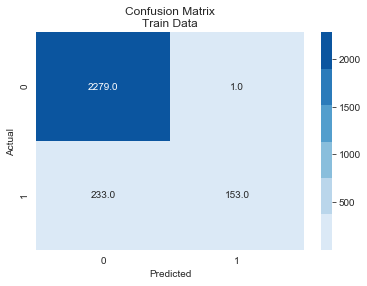

Precision Score: 0.9935064935064936
Recall Score: 0.3963730569948187
Accuracy Score: 0.9122280570142536
F1 Score: 0.5666666666666668


In [38]:
plot_confusion_matrix(y_train,rf_best.predict(X_train),data='Train')
print_metrics(y_train,rf_best.predict(X_train))

7.646176911544228 of False Negatives


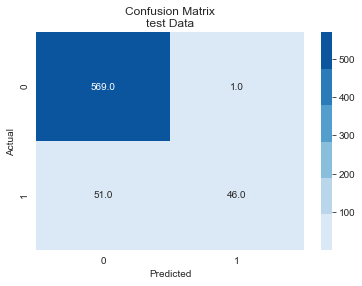

Precision Score: 0.9787234042553191
Recall Score: 0.4742268041237113
Accuracy Score: 0.9220389805097451
F1 Score: 0.6388888888888888


In [39]:
plot_confusion_matrix(y_test,rf_preds)
print_metrics(y_test,rf_preds)

8.52085208520852 of False Negatives


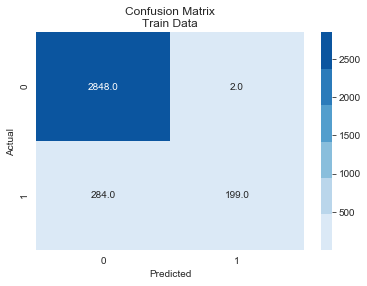

Precision Score: 0.9900497512437811
Recall Score: 0.41200828157349895
Accuracy Score: 0.9141914191419142
F1 Score: 0.5818713450292398


In [40]:
plot_confusion_matrix(y,rf_best.predict(X),data='Train')
print_metrics(y,rf_best.predict(X))

# RF with SMOTE

In [41]:
rf_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('RF',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                       

In [42]:
rf_best = rf_cv.best_estimator_
rf_cv.best_params_

{'RF__criterion': 'entropy',
 'RF__max_depth': 6,
 'RF__min_samples_leaf': 3,
 'RF__min_samples_split': 5}

In [43]:
rf_best.score(X_train_smote,y_train_smote),rf_best.score(X_test,y_test)

(0.8585526315789473, 0.8725637181409296)

In [44]:
rf_preds = rf_best.predict(X_test)

10.701754385964913 of False Negatives


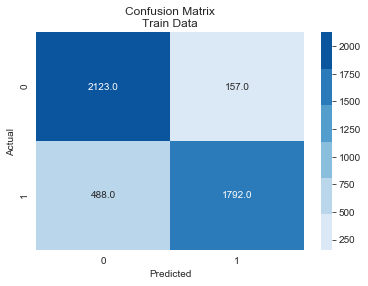

Precision Score: 0.9194458696767573
Recall Score: 0.7859649122807018
Accuracy Score: 0.8585526315789473
F1 Score: 0.8474816741546465


In [45]:
plot_confusion_matrix(y_train_smote,rf_best.predict(X_train_smote),data='Train')
print_metrics(y_train_smote,rf_best.predict(X_train_smote))

4.94752623688156 of False Negatives


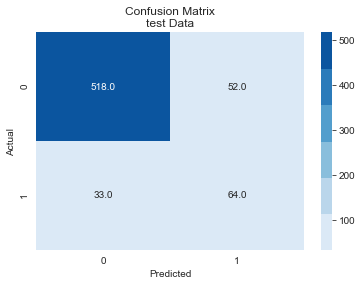

Precision Score: 0.5517241379310345
Recall Score: 0.6597938144329897
Accuracy Score: 0.8725637181409296
F1 Score: 0.6009389671361501


In [46]:
plot_confusion_matrix(y_test,rf_preds)
print_metrics(y_test,rf_preds)

4.9504950495049505 of False Negatives


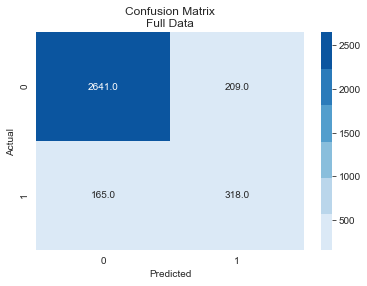

Precision Score: 0.603415559772296
Recall Score: 0.6583850931677019
Accuracy Score: 0.8877887788778878
F1 Score: 0.6297029702970297


In [47]:
plot_confusion_matrix(y,rf_best.predict(X),data='Full')
print_metrics(y,rf_best.predict(X))

In [53]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')


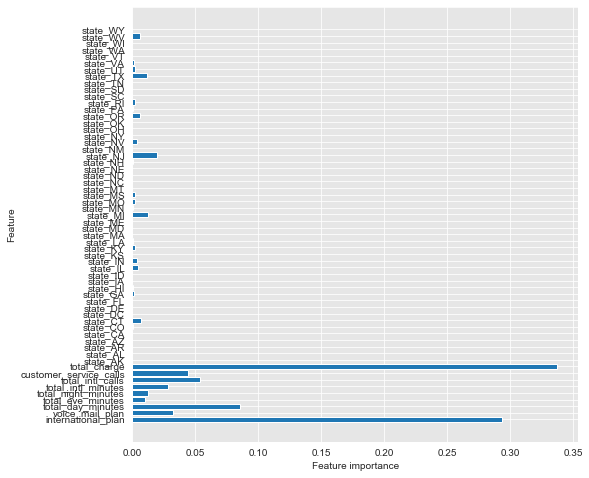

In [54]:
plot_feature_importances(rf_best[1])

In [55]:
print(classification_report(y_test,rf_preds))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       570
           1       0.55      0.66      0.60        97

    accuracy                           0.87       667
   macro avg       0.75      0.78      0.76       667
weighted avg       0.88      0.87      0.88       667



# Bayesian

In [56]:
bayes = GaussianNB()

In [57]:
bayes.fit(X_train_smote,y_train_smote)

GaussianNB(priors=None, var_smoothing=1e-09)

In [58]:
bayes.score(X_train_smote,y_train_smote),bayes.score(X_test,y_test)

(0.6732456140350878, 0.5697151424287856)

In [60]:
y_test_bayes = bayes.predict(X_test)


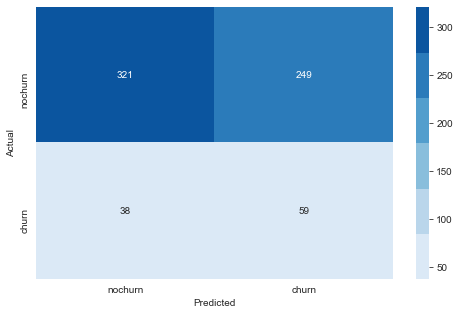

In [61]:
labels = ["nochurn", "churn"]
plot_confusion_matrix2(y_test, y_test_bayes, labels=labels)


In [62]:
df_test = X_test.copy()

In [63]:
churn_probs = bayes.predict_proba(X_test)[:, 1]
df_test['label'] = y_test
df_test['churn_prob'] = churn_probs

In [64]:
df_test.head()

,international_plan,voice_mail_plan,total_day_minutes,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,customer_service_calls,total_charge,state_AK,...,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,label,churn_prob
2753,0,0,7.8,171.4,186.5,12.9,2,2,27.77,0,...,0,0,0,0,0,0,0,0,0,0.808553
2575,0,0,131.6,179.3,251.2,15.5,3,1,53.10,0,...,0,0,0,0,0,0,0,0,1,1.000000
1888,0,0,191.1,282.8,84.8,12.0,4,2,63.59,0,...,0,0,0,0,1,0,0,0,0,1.000000
126,0,0,70.7,157.5,154.8,9.1,3,4,34.84,0,...,0,0,0,0,0,0,0,0,1,1.000000
2116,0,0,195.6,126.4,148.6,14.2,4,1,54.51,0,...,0,0,0,0,0,0,0,0,0,0.999999


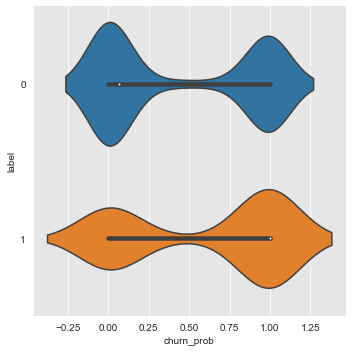

In [65]:
sns.catplot(x='churn_prob', y='label', orient='h', data=df_test, kind='violin')
plt.show()

In [66]:
df_test['predicted_label'] = bayes.predict(X_test)
df_test.head()

,international_plan,voice_mail_plan,total_day_minutes,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,customer_service_calls,total_charge,state_AK,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,label,churn_prob,predicted_label
2753,0,0,7.8,171.4,186.5,12.9,2,2,27.77,0,...,0,0,0,0,0,0,0,0,0.808553,1
2575,0,0,131.6,179.3,251.2,15.5,3,1,53.10,0,...,0,0,0,0,0,0,0,1,1.000000,1
1888,0,0,191.1,282.8,84.8,12.0,4,2,63.59,0,...,0,0,0,1,0,0,0,0,1.000000,1
126,0,0,70.7,157.5,154.8,9.1,3,4,34.84,0,...,0,0,0,0,0,0,0,1,1.000000,1
2116,0,0,195.6,126.4,148.6,14.2,4,1,54.51,0,...,0,0,0,0,0,0,0,0,0.999999,1


In [67]:
df_test['correct'] = df_test['label']==df_test['predicted_label']
df_test.head()

,international_plan,voice_mail_plan,total_day_minutes,total_eve_minutes,total_night_minutes,total_intl_minutes,total_intl_calls,customer_service_calls,total_charge,state_AK,...,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,label,churn_prob,predicted_label,correct
2753,0,0,7.8,171.4,186.5,12.9,2,2,27.77,0,...,0,0,0,0,0,0,0,0.808553,1,False
2575,0,0,131.6,179.3,251.2,15.5,3,1,53.10,0,...,0,0,0,0,0,0,1,1.000000,1,True
1888,0,0,191.1,282.8,84.8,12.0,4,2,63.59,0,...,0,0,1,0,0,0,0,1.000000,1,False
126,0,0,70.7,157.5,154.8,9.1,3,4,34.84,0,...,0,0,0,0,0,0,1,1.000000,1,True
2116,0,0,195.6,126.4,148.6,14.2,4,1,54.51,0,...,0,0,0,0,0,0,0,0.999999,1,False


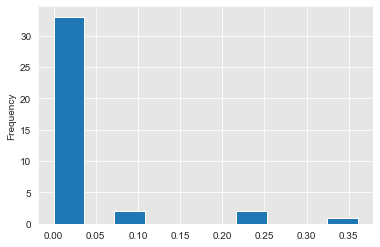

In [68]:
df_test_inc_churn = df_test.loc[(df_test['correct']==False) & (df_test['label']==1)]
df_test_inc_churn['churn_prob'].plot('hist')

In [69]:
# let's try a 20% threshold to make our labels

def bayes_labels(X_test, thresh=0.30):
    """
    custom predict method
    """
    probs = bayes.predict_proba(X_test)[:, 1]
    labels = []
    for prob in probs:
        if prob >= thresh:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [70]:
bayes.predict_custom = bayes_labels

5.697151424287856 of False Negatives


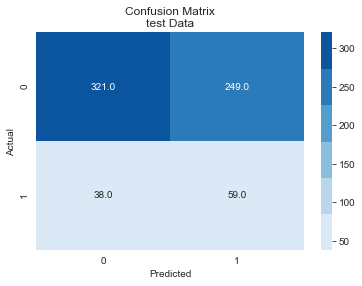

4.6476761619190405 of False Negatives


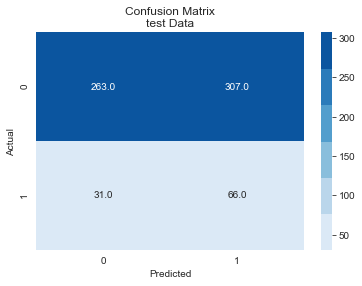

In [73]:
new_labels = bayes.predict_custom(X_test,thresh=0.01)
plot_confusion_matrix(y_test, y_test_bayes)
plot_confusion_matrix(y_test, new_labels)

# XG Boost - built in class imbalance

In [117]:
train_classifiers = y_train.value_counts()
scaler = train_classifiers[0]/train_classifiers[1]
scaler

5.9067357512953365

In [118]:
scaler = train_classifiers[0]/train_classifiers[1]
scaler

5.9067357512953365

In [119]:
xgb_pipeline = Pipeline([('ss',StandardScaler()),('xgb',xgb.XGBClassifier(objective='binary:logistic',scale_pos_weight=scaler))])


In [120]:
params = {
    "xgb__learning_rate": [0.001,0.05,0.01,0.1,0.5],
    'xgb__max_depth': [3,5,7],
    'xgb__subsample': [1],
    'xgb__n_estimators': [5, 50, 100, 250,500,750],
}

In [121]:
xgb_cv = GridSearchCV(estimator =xgb_pipeline,param_grid=params,n_jobs=-1,scoring=make_scorer(recall_score),cv=5)

In [122]:
xgb_cv.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                            

In [123]:
xgb_best = xgb_cv.best_estimator_

In [124]:
xgb_cv.best_params_

{'xgb__learning_rate': 0.001,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 5,
 'xgb__subsample': 1}

In [125]:
xgb_best.score(X_train,y_train),xgb_best.score(X_test,y_test)

(0.9257314328582146, 0.9280359820089955)

In [126]:
xgb_preds = xgb_best.predict(X_test)

2.213053263315829 of False Negatives


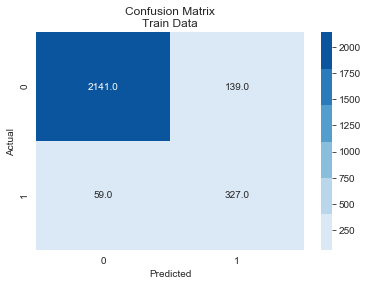

Precision Score: 0.7017167381974249
Recall Score: 0.8471502590673575
Accuracy Score: 0.9257314328582146
F1 Score: 0.767605633802817


In [127]:
plot_confusion_matrix(y_train,xgb_best.predict(X_train),data='Train')
print_metrics(y_train,xgb_best.predict(X_train))

1.3493253373313343 of False Negatives


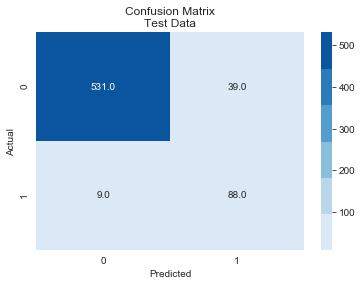

Precision Score: 0.6929133858267716
Recall Score: 0.9072164948453608
Accuracy Score: 0.9280359820089955
F1 Score: 0.7857142857142857


In [128]:
plot_confusion_matrix(y_test,xgb_preds,data='Test')
print_metrics(y_test,xgb_preds)

2.04020402040204 of False Negatives


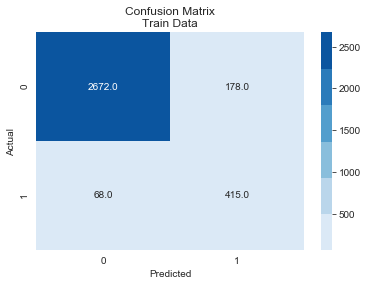

Precision Score: 0.6998313659359191
Recall Score: 0.8592132505175983
Accuracy Score: 0.9261926192619262
F1 Score: 0.7713754646840149


In [129]:
plot_confusion_matrix(y,xgb_best.predict(X),data='Train')
print_metrics(y,xgb_best.predict(X))

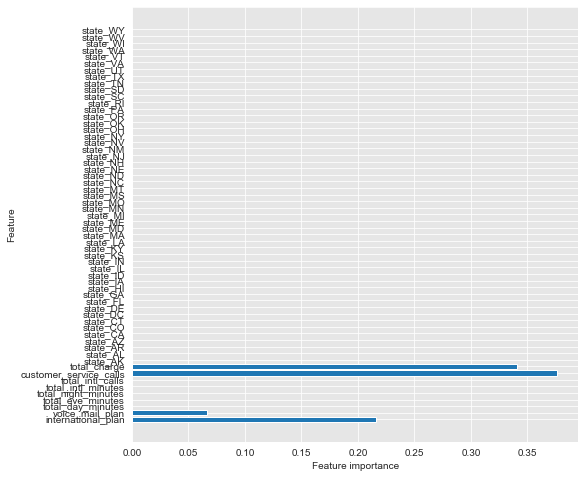

In [130]:
plot_feature_importances(xgb_best[1])

In [88]:
xgb_best[1].feature_importances_

array([0.21637742, 0.06655852, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.37632507, 0.34073892, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [89]:
X_train.columns.values


array(['international_plan', 'voice_mail_plan', 'total_day_minutes',
       'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes',
       'total_intl_calls', 'customer_service_calls', 'total_charge',
       'state_AK', 'state_AL', 'state_AR', 'state_AZ', 'state_CA',
       'state_CO', 'state_CT', 'state_DC', 'state_DE', 'state_FL',
       'state_GA', 'state_HI', 'state_IA', 'state_ID', 'state_IL',
       'state_IN', 'state_KS', 'state_KY', 'state_LA', 'state_MA',
       'state_MD', 'state_ME', 'state_MI', 'state_MN', 'state_MO',
       'state_MS', 'state_MT', 'state_NC', 'state_ND', 'state_NE',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY',
       'state_OH', 'state_OK', 'state_OR', 'state_PA', 'state_RI',
       'state_SC', 'state_SD', 'state_TN', 'state_TX', 'state_UT',
       'state_VA', 'state_VT', 'state_WA', 'state_WI', 'state_WV',
       'state_WY'], dtype=object)

# XGBoost with SMOTE

In [105]:
xgb_smote_pipeline = Pipeline([('ss',StandardScaler()),('xgb',xgb.XGBClassifier(objective='binary:logistic'))])


In [106]:

xgb__smote_cv = GridSearchCV(estimator =xgb_smote_pipeline,param_grid=params,n_jobs=-1,
                            scoring=make_scorer(recall_score),cv=5)

In [107]:
xgb__smote_cv.fit(X_train_smote,y_train_smote)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ss',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.1,
                                                      max_delta_step=0,
                            

In [108]:
xgb_best_smote = xgb__smote_cv.best_estimator_

In [109]:
xgb__smote_cv.best_params_

{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 7,
 'xgb__n_estimators': 250,
 'xgb__subsample': 1}

In [110]:
xgb_best_smote.score(X_train_smote,y_train_smote),xgb_best_smote.score(X_test,y_test)

(0.9929824561403509, 0.9850074962518741)

In [111]:
xgb_preds_smote = xgb_best_smote.predict(X_test)

0.7017543859649122 of False Negatives


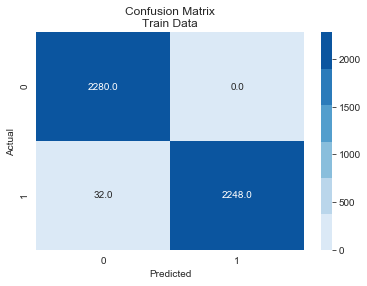

Precision Score: 1.0
Recall Score: 0.9859649122807017
Accuracy Score: 0.9929824561403509
F1 Score: 0.9929328621908127


In [112]:
plot_confusion_matrix(y_train_smote,xgb_best_smote.predict(X_train_smote),data='Train')
print_metrics(y_train_smote,xgb_best_smote.predict(X_train_smote))

1.3493253373313343 of False Negatives


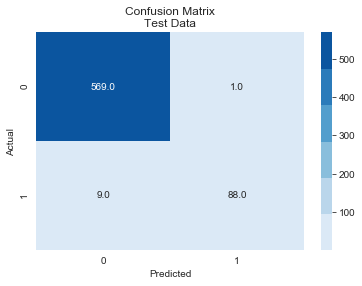

Precision Score: 0.9887640449438202
Recall Score: 0.9072164948453608
Accuracy Score: 0.9850074962518741
F1 Score: 0.9462365591397849


In [113]:
plot_confusion_matrix(y_test,xgb_preds_smote,data='Test')
print_metrics(y_test,xgb_preds_smote)

1.2301230123012301 of False Negatives


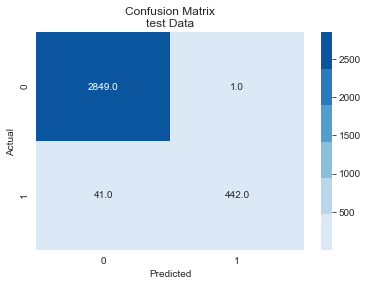

Precision Score: 0.9977426636568849
Recall Score: 0.9151138716356108
Accuracy Score: 0.9873987398739874
F1 Score: 0.9546436285097192


In [114]:
plot_confusion_matrix(y,xgb_best_smote.predict(X))
print_metrics(y,xgb_best_smote.predict(X))

1.2003000750187547 of False Negatives


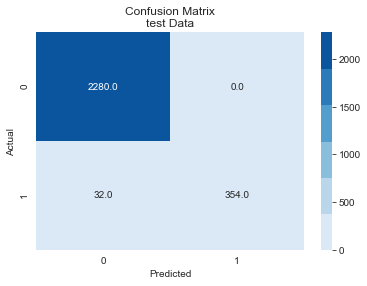

Precision Score: 1.0
Recall Score: 0.917098445595855
Accuracy Score: 0.9879969992498124
F1 Score: 0.9567567567567568


In [115]:
plot_confusion_matrix(y_train,xgb_best_smote.predict(X_train))
print_metrics(y_train,xgb_best_smote.predict(X_train))

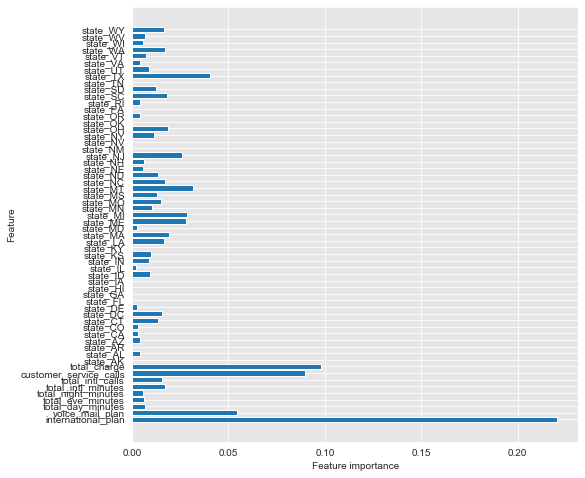

In [116]:
plot_feature_importances(xgb_best_smote[1])

# Is there a threshold to reduce False Negatives?

In [213]:
# let's try a 20% threshold to make our labels

def xgb_labels(X_test, thresh=0.2):
    """
    custom predict method
    """
    probs = xgb_best_smote.predict_proba(X_test)[:, 1]
    labels = []
    for prob in probs:
        if prob >= thresh:
            labels.append(1)
        else:
            labels.append(0)
    return labels

1.199400299850075 of False Negatives


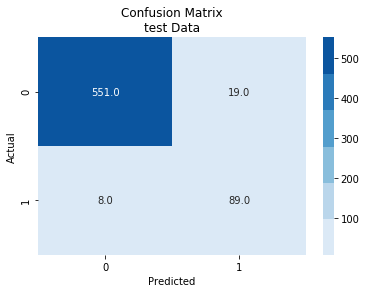

In [214]:
xgb_best.predict_custom = xgb_labels
new_labels = xgb_best.predict_custom(X_test,thresh=0.1)
plot_confusion_matrix(y_test, new_labels)

In [215]:
xgb_best_smote.predict_custom = xgb_labels

1.3493253373313343 of False Negatives


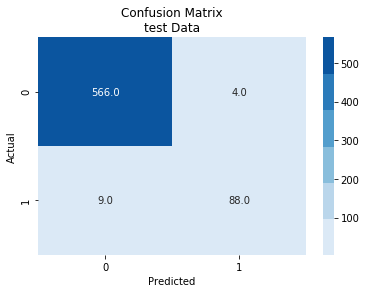

In [216]:
plot_confusion_matrix(y_test,xgb_preds_smote)

0.30007501875468867 of False Negatives


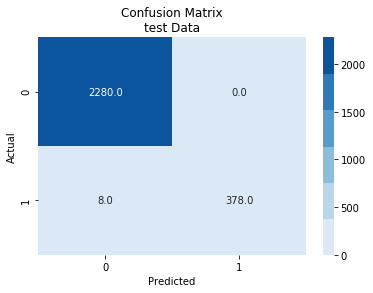

In [354]:
new_labels = xgb_best_smote.predict_custom(X_train,thresh=0.25)
plot_confusion_matrix(y_train, new_labels)

0.29985007496251875 of False Negatives


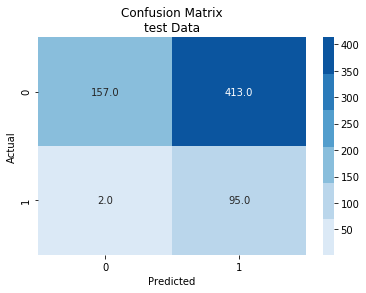

In [355]:
new_labels = xgb_best_smote.predict_custom(X_test,thresh=0.01)
plot_confusion_matrix(y_test, new_labels)

0.14992503748125938 of False Negatives


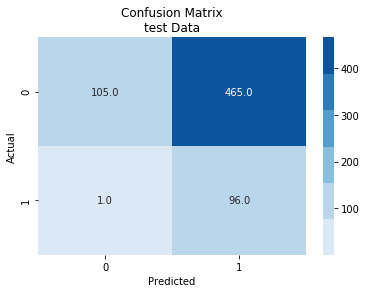

In [356]:
new_labels = xgb_best_smote.predict_custom(X_test,thresh=0.008)
plot_confusion_matrix(y_test, new_labels)

IT is clear that as FN go to 0 , FP get extremely large. This is because our model predicts nearly everything as 
a churn - to make sure that we dont accidentally say they wont churn if they will
This makes our model a bit redundant

# Exploring the False Negatives for Test Set

In [357]:
d = {'y_test':y_test,'y_pred':xgb_preds_smote}

In [358]:
dfpreds = pd.DataFrame(data=d)

In [359]:
dfpreds['correct'] = dfpreds['y_test']==dfpreds['y_pred']

In [360]:
dfpreds['correct'].value_counts()

True     654
False     13
Name: correct, dtype: int64

In [372]:
dfcorrect = dfpreds.loc[(dfpreds['correct']==False)&(dfpredswhole['y_pred']==0)]

In [373]:
indexlist = dfcorrect.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this


In [374]:
FN = dfcorrect.loc[dfcorrect['y_pred']==0]

In [375]:
FN

,y_test,y_pred,correct
2575,1,0,False
1939,1,0,False
2357,1,0,False
3070,1,0,False
1551,1,0,False
2377,1,0,False
2535,1,0,False
198,1,0,False
1030,1,0,False


In [376]:
indexlist = FN.index.values.tolist()  # an ndarray method, you probably shouldn't depend on this
indexlist

[2575, 1939, 2357, 3070, 1551, 2377, 2535, 198, 1030]

In [377]:
dfFN = df.loc[indexlist]

In [378]:
dfFN

,index,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
2575,2575,MS,131,415,333-9002,0,0,0,131.6,95,...,15.5,3,4.19,1,1,53.10,10,577.6,0.091932,336
1939,1939,AZ,113,510,403-9719,0,0,0,128.7,100,...,9.2,4,2.48,2,1,51.67,9,543.1,0.095139,306
2357,2357,WI,153,510,349-3112,0,0,0,159.5,103,...,10.1,2,2.73,1,1,61.22,12,621.8,0.098456,321
3070,3070,MD,154,510,411-2977,0,0,0,154.5,122,...,12.0,2,3.24,3,1,55.73,12,558.7,0.099749,300
1551,1551,MI,225,415,371-2500,0,0,0,165.4,106,...,8.7,3,2.35,0,1,63.18,18,657.8,0.096047,311
2377,2377,ND,101,415,364-5510,0,1,36,123.7,125,...,8.8,4,2.38,1,1,50.70,8,585.6,0.086578,362
2535,2535,RI,125,408,410-3159,0,0,0,113.0,108,...,9.2,5,2.48,2,1,43.12,10,448.0,0.096250,281
198,198,ME,131,510,353-7292,1,1,26,292.9,101,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332
1030,1030,VA,99,415,400-6257,0,1,42,216.0,125,...,9.3,4,2.51,2,1,68.68,8,673.1,0.102035,333


In [379]:
df.loc[df['churn']==0]['total_charge'].mean()

58.448807017543864

In [380]:
dfFN.loc[dfFN['total_charge']<60]

,index,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
2575,2575,MS,131,415,333-9002,0,0,0,131.6,95,...,15.5,3,4.19,1,1,53.10,10,577.6,0.091932,336
1939,1939,AZ,113,510,403-9719,0,0,0,128.7,100,...,9.2,4,2.48,2,1,51.67,9,543.1,0.095139,306
3070,3070,MD,154,510,411-2977,0,0,0,154.5,122,...,12.0,2,3.24,3,1,55.73,12,558.7,0.099749,300
2377,2377,ND,101,415,364-5510,0,1,36,123.7,125,...,8.8,4,2.38,1,1,50.70,8,585.6,0.086578,362
2535,2535,RI,125,408,410-3159,0,0,0,113.0,108,...,9.2,5,2.48,2,1,43.12,10,448.0,0.096250,281


5 out of 9 data points had a total charge less than 60. This is the most important feature in our model and assumes charges above average will be more liekly to churn

In [381]:
dfFN.loc[dfFN['customer_service_calls']>3]

,index,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,198,ME,131,510,353-7292,1,1,26,292.9,101,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 out of the 9 False Negatives made more than 3 customer services calls
- This shows that our model struggles to classify points when customers dont make a lot of customer service calls

In [382]:
dfFN.loc[dfFN['international_plan']==1]

,index,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,198,ME,131,510,353-7292,1,1,26,292.9,101,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 of the 9 values had an international plan.
Again our model puts a lot of bias on international plans churning so this is why it is classified incorrectly

# Conclusion:

Looking at the False Negatives from our test set - that is we predicted them to stay and they churned, I wanted to see what these data points had in common

8/9 of them had made less than 3 calls to customer service
only 1/9 of them had an international plan
5/9 paid less than the average charge for the whole dataset

This leads me to belive that these points lie within the unpredictable - there is no partiular reason from a business case why they left, and is proabbly down to customer descretion and personal circumstances

# Exploring False Negatives for Entire DataSet

1.2301230123012301 of False Negatives


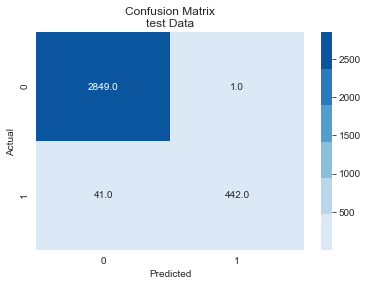

Precision Score: 0.9977426636568849
Recall Score: 0.9151138716356108
Accuracy Score: 0.9873987398739874
F1 Score: 0.9546436285097192


In [131]:
plot_confusion_matrix(y,xgb_best_smote.predict(X))
print_metrics(y,xgb_best_smote.predict(X))

In [132]:
d = {'y':y,'y_pred':xgb_best_smote.predict(X)}

In [133]:
dfpredswhole = pd.DataFrame(data=d)
dfpredswhole

,y,y_pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
3328,0,0
3329,0,0
3330,0,0
3331,0,0


In [134]:
dfpredswhole['correct'] = dfpredswhole['y']==dfpredswhole['y_pred']

In [135]:
FN_whole = dfpredswhole.loc[(dfpredswhole['correct']==False) & (dfpredswhole['y_pred']==0)]

In [136]:
FN_whole.shape

(41, 3)

In [137]:
indexlist = FN_whole.index.values.tolist() 

In [138]:
FN_whole_data = df.loc[indexlist]

In [139]:
df.loc[df['churn']==0]['total_charge'].mean()

58.448807017543864

In [140]:
FN_whole_data.loc[FN_whole_data['total_charge']<60].shape

(21, 26)

21 out of the 41 data points had a total charge less than 60. This is the most important feature in our model and assumes charges above average will be more liekly to churn

In [141]:
FN_whole_data.loc[FN_whole_data['customer_service_calls']>3]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 out of the 41 False Negatives made more than 3 customer services calls
- This shows that our model struggles to classify points when customers dont make a lot of customer service calls

In [142]:
FN_whole_data.loc[FN_whole_data['international_plan']==1]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332


Only 1 of the 41 values had an international plan.
Again our model puts a lot of bias on international plans churning so this is why it is classified incorrectly

In [143]:
FN_whole_data.loc[FN_whole_data['voice_mail_plan']==1]

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn,total_charge,tenor_years,total_minutes,avg_price_per_min,total_calls
57,CO,121,408,370-7574,0,1,30,198.4,129,33.73,...,5.8,3,1.57,3,1,49.85,10,460.7,0.108205,286
198,ME,131,510,353-7292,1,1,26,292.9,101,49.79,...,13.8,7,3.73,4,1,81.98,10,761.7,0.107628,332
277,SD,144,408,339-3049,0,1,48,189.8,96,32.27,...,6.5,2,1.76,2,1,54.16,12,533.9,0.101442,271
466,FL,132,510,334-9505,0,1,36,226.2,103,38.45,...,10.5,5,2.84,3,1,68.38,11,677.1,0.100990,335
892,LA,109,415,395-6195,0,1,27,166.9,85,28.37,...,12.3,4,3.32,1,1,59.37,9,597.7,0.099331,278
968,NM,122,408,370-9755,0,1,33,174.9,103,29.73,...,13.5,3,3.65,1,1,61.89,10,601.2,0.102944,327
1030,VA,99,415,400-6257,0,1,42,216.0,125,36.72,...,9.3,4,2.51,2,1,68.68,8,673.1,0.102035,333
1254,MN,62,510,390-9811,0,1,33,186.4,84,31.69,...,11.1,3,3.00,2,1,64.68,5,685.2,0.094396,326
1263,MA,40,408,351-7005,0,1,31,224.7,69,38.20,...,7.5,5,2.03,1,1,57.07,3,487.0,0.117187,259
1454,UT,133,408,398-8745,0,1,44,174.0,80,29.58,...,14.1,7,3.81,2,1,61.27,11,621.6,0.098568,287


# Conclusion

Many of these values were misclassified because they didnt fit the general mould of our model
* International plan
* High Total Charge
* More than 3 customer service calls

This could mean that their churn is not business related at all - and more down to personal circumstance - which we cannot account for.
Alternatively, we need to expand our model to find more segements that cause churn